# [Item-based Collaborative Filtering](https://hipster4020.tistory.com/114?category=856880)
최근접 이웃 협업 필터링은 사용자 기반과 아이템 기반으로 분류하는데, 이 중 일반적으로 추천 정확도가 더 뛰어난 아이템 기반의 협업 필터링을 구현해 보겠습니다.    

매우 유명한 아이템은 취향과 관계없이 대부분의 사람이 보고 평가하는 경우가 많습니다. 하지만 대부분의 경우에는 사용자들이 도서(또는 상품)에 대해 평가를 매기지 않은 경우가 일반적이라 다른 사람과의 유사도를 비교하기가 어렵습니다.   
따라서 최근접 이웃 협업 필터링은 대부분 아이템 기반의 알고리즘을 적용합니다.

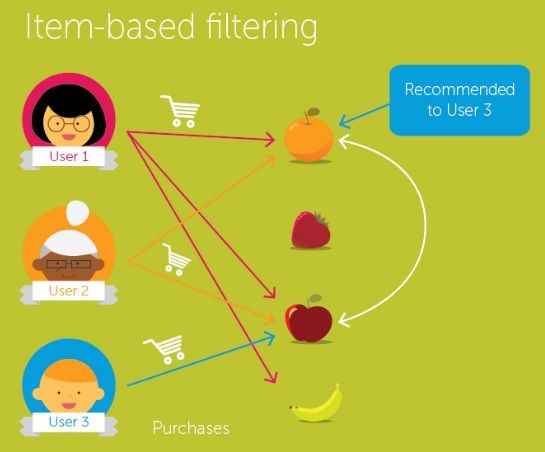

## 아이템 기반 최근접 이웃 기반 협업 필터링
아이템이 가지는 속성과는 상관없이 사용자들의 선호도에 대해 평가합니다.  
척도가 유사한 아이템을 추천하는 기준이 되는 알고리즘입니다.

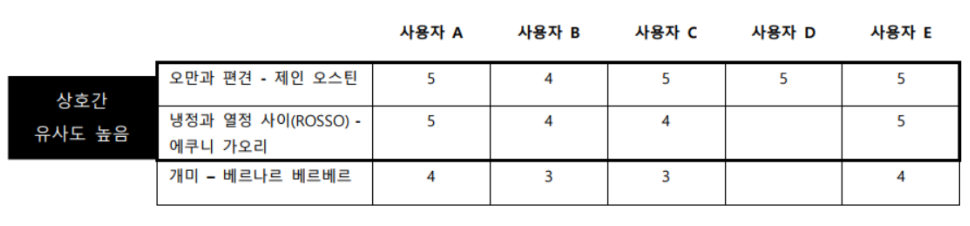

- 위 표에서 제인 오스틴의 고전작 '오만과 편견'과 에쿠니 가오리의 '냉정과 열정 사이'의 독자들의 평점이 유사합니다.
- 아이템(도서) '오만과 편견'은 '개미'보다 '냉정과 열정 사이'와 사용자들의 평점 분포가 훨씬 더 비슷하므로 '오만과 편견'과 '냉정과 열정 사이'는 아이템 유사도가 상대적으로 매우 높게 나오며, 높은 유사도를 바탕으로 사용자 D에게 '냉정과 열정 사이'를 추천할 수 있습니다.

In [1]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


# [데이터 가공 및 변환](https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset?select=Book+reviews)

In [2]:
import numpy as np 
import pandas as pd 

from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.metrics import mean_squared_error 

In [3]:
DATA_PATH = "/content/data/MyDrive/lecture/6. deep learning/7-4. RS_Pytorch/data/Book reviews/"

bxbooks = pd.read_csv(DATA_PATH+'BX_Books.csv', sep= ';', encoding="latin-1")
bxbookratings = pd.read_csv(DATA_PATH+'BX-Book-Ratings.csv', sep= ';', encoding="latin-1")

bxbooks.shape, bxbookratings.shape 

((271379, 8), (1149780, 3))

In [4]:
bxbooks.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
bxbookratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## 결측치 확인 

In [6]:
bxbooks.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [7]:
bxbookratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [8]:
bxbooks.shape, bxbookratings.shape 

((271379, 8), (1149780, 3))

## 데이터 사이즈 조정 
- bxbookratings 데이터는 사용자별로 도서에 대한 평점을 매긴 데이터 세트입니다. 이것 역시 데이터 건수가 너무 많아 50,000으로 줄이겠습니다.  

In [9]:
# 데이터 사이즈 조정
bxbookratings = bxbookratings[:50000]

bxbooks.shape, bxbookratings.shape

((271379, 8), (50000, 3))

# 도서간 유사도 산출 

## pivot_table 생성 
협헙 필터링은 사용자와 아이템 간의 평점(또는 다른 유형의 액션)에 기반해 추천하는 시스템입니다. 먼저 DataFrame의 pivot_table()를 이용하여 로우(행) 레벨 데이터의 원본 데이터 세트를 모든 사용자를 로우로, 모든 도서를 컬럼으로 구성하는 데이터 세트로 변경해야 합니다.

In [10]:
bxbookratings = bxbookratings[['User-ID', 'ISBN',	'Book-Rating']]
bxbookratings_matrix = bxbookratings.pivot_table('Book-Rating', index='User-ID', columns='ISBN')

print(f'{bxbookratings_matrix.shape}')
bxbookratings_matrix.head()

(5064, 36282)


ISBN,9022906116,0 7336 1053 6,0/330/25864/8,00 14 02 5314,000000000,0000000000,00000000000,0000000124911,000000078245,000000168274,...,O451160533,O553375067,O571200338,O590603647,O6712345670,O76790592X,O809463121,"\0210000010""","\0432534220\""""","\2842053052\"""""
User-ID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 거의 모든 데이터가 NaN으로 보이는 이유는 사용자가 평점을 매기지 않은 도서가 컬럼으로 변환되면서 NaN으로 할당되었기 때문입니다.   
- NaN 데이터를 처리하기 전에, ISBN 값을 각각 해당하는 bxbooks 데이터 세트에 있는 도서명으로 변경하겠습니다.
- bxbookratings와 bxbooks를 조인해 Book-Title 컬럼을 가지고 다시 피벗(pivot)한 후에 NaN은 0으로 변환합니다.

In [11]:
# title 컬럼을 얻기 위해 movies와 조인
rating_books = pd.merge(bxbookratings, bxbooks, on='ISBN')

print(f'{rating_books.shape}')
rating_books.head()

(43975, 10)


,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [12]:
# columns='title'로 title 컬럼으로 피벗 수행.
ratings_matrix = rating_books.pivot_table('Book-Rating', index='User-ID', columns='Book-Title')

print(f'{ratings_matrix.shape}')
ratings_matrix.head()

(4374, 28726)


Book-Title,Beyond IBM: Leadership Marketing and Finance for the 1990s,It Takes Two,"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",Mystery Mile,Tales of Terror and Suspense,"' Sie belieben wohl zu scherzen, Mr. Feynman.'. Abenteuer eines neugierigen Physikers.",'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,'Salem's Lot,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,...,eXistenZ: A Novelization,flambeau@darkcorp.com,iI Paradiso Degli Orchi,"metamorfosis, La (ClÃ¡sicos selecciÃ³n series)",stardust,"street bible, the",the Heiress Bride (sister brides),Â¡No bajes al sÃ³tano! (EscalofrÃ­os No. 2),Â¿QuiÃ©n se ha llevado mi queso?,Ã?Â?bermorgen.
User-ID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# NaN 값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)

print(f'{ratings_matrix.isnull().sum().sum()}')
ratings_matrix.head()

0


Book-Title,Beyond IBM: Leadership Marketing and Finance for the 1990s,It Takes Two,"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",Mystery Mile,Tales of Terror and Suspense,"' Sie belieben wohl zu scherzen, Mr. Feynman.'. Abenteuer eines neugierigen Physikers.",'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,'Salem's Lot,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,...,eXistenZ: A Novelization,flambeau@darkcorp.com,iI Paradiso Degli Orchi,"metamorfosis, La (ClÃ¡sicos selecciÃ³n series)",stardust,"street bible, the",the Heiress Bride (sister brides),Â¡No bajes al sÃ³tano! (EscalofrÃ­os No. 2),Â¿QuiÃ©n se ha llevado mi queso?,Ã?Â?bermorgen.
User-ID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 유사도 산출

변환된 사용자-아이템 테이블을 사이킷런의 cosine_similarity()를 이용하여 코사인 유사도를 기반으로 측정합니다.    

cosine_similarity()는 아이템 행을 기준으로 서로 다른 행을 비교해 유사도를 산출합니다.
- 아이템을 기준으로 cosine_similarity()를 적용하려면 행 기준 : 아이템, 열 기준 : 사용자가 되어야 하는데, 현재 생성한 ratings_matrix 테이블은 사용자-아이템 기반임으로 행과 열을 변경해야 합니다.  
- 전치 행렬 변경을 위해 pandas의 transpose()를 이용하여 ratings_matrix 데이터의 행과 열 위치를 변경합니다.  

In [14]:
ratings_matrix_T = ratings_matrix.transpose()

print(f'{ratings_matrix_T.shape}')
ratings_matrix_T.head()

(28726, 4374)


User-ID,2,8,9,10,12,14,16,17,19,20,...,278832,278836,278838,278843,278844,278846,278849,278851,278852,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
Beyond IBM: Leadership Marketing and Finance for the 1990s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
It Takes Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mystery Mile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tales of Terror and Suspense,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


생성된 전치 행렬 데이터 세트를 토대로 코사인 유사도를 측정하겠습니다.

In [15]:
item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T) 

item_sim.shape 

(28726, 28726)

In [16]:
# cosine_similarity()로 반환된 Numpy 행렬을 도서명으로 매핑해 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                           columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head()

(28726, 28726)


Book-Title,Beyond IBM: Leadership Marketing and Finance for the 1990s,It Takes Two,"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",Mystery Mile,Tales of Terror and Suspense,"' Sie belieben wohl zu scherzen, Mr. Feynman.'. Abenteuer eines neugierigen Physikers.",'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,'Salem's Lot,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,...,eXistenZ: A Novelization,flambeau@darkcorp.com,iI Paradiso Degli Orchi,"metamorfosis, La (ClÃ¡sicos selecciÃ³n series)",stardust,"street bible, the",the Heiress Bride (sister brides),Â¡No bajes al sÃ³tano! (EscalofrÃ­os No. 2),Â¿QuiÃ©n se ha llevado mi queso?,Ã?Â?bermorgen.
Book-Title,,,,,,,,,,,,,,,,,,,,,
Beyond IBM: Leadership Marketing and Finance for the 1990s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
It Takes Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mystery Mile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tales of Terror and Suspense,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


101 Dalmatians을 기준으로 유사도가 높은 상위 5건 추출해보겠습니다.

In [17]:
item_sim_df["101 Dalmatians"].sort_values(ascending=False)[:5]

Book-Title
101 Dalmatians                                   1.000000
The White Dragon (Dragonriders of Pern Vol 3)    0.780869
MISS PYM DISPOSES                                0.780869
Olive and the Magic Hat                          0.780869
Vanishing Point: A Miss Silver Mystery           0.780869
Name: 101 Dalmatians, dtype: float64

1984을 기준으로 확인해보겠습니다.

In [18]:
item_sim_df["1984"].sort_values(ascending=False)[:5]

Book-Title
1984                                                                                                         1.000000
The Lion, the Witch, and the Wardrobe (The Chronicles of Narnia, Book 2)                                     0.464057
The Ethical Slut: A Guide to Infinite Sexual Possibilities                                                   0.391931
The Tao of Love and Sex                                                                                      0.391931
The Western Guide to Feng Shui: Creating Balance, Harmony, and Prosperity in Your Environment (Feng Shui)    0.391931
Name: 1984, dtype: float64

# 개인화된 도서 추천

개인이 아직 읽지 않은 도서에 대해 아이템 유사도와 기존에 읽은 도서의 평점 데이터를 가지고 다른 모든 도서의 예측 평점을 계산한 후 높은 예측 평점을 가진 도서를 추천하는 방식입니다.  

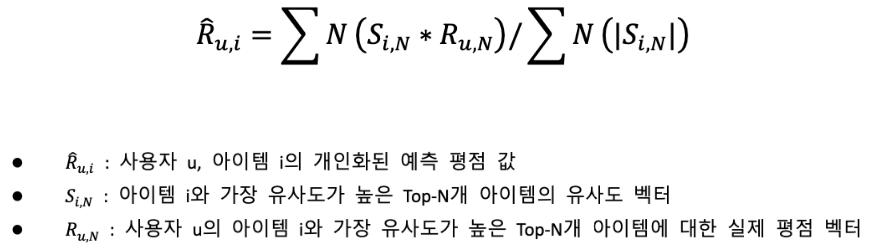

In [19]:
# 예측 평점 계산식 함수 구현
def predict_rating(ratings_arr, item_sim_arr):

    # dot : 내적을 이용한 가중합 계산
    ratings_pred = ratings_arr.dot(item_sim_arr) / np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred

In [20]:
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)

<ipython-input-19-b78cd84be24e>:5: RuntimeWarning: invalid value encountered in divide
  ratings_pred = ratings_arr.dot(item_sim_arr) / np.array([np.abs(item_sim_arr).sum(axis=1)])


In [21]:
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, 
                                   columns = ratings_matrix.columns)

print(f'{ratings_pred_matrix.shape}')
ratings_pred_matrix.head()

(4374, 28726)


Book-Title,Beyond IBM: Leadership Marketing and Finance for the 1990s,It Takes Two,"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",Mystery Mile,Tales of Terror and Suspense,"' Sie belieben wohl zu scherzen, Mr. Feynman.'. Abenteuer eines neugierigen Physikers.",'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,'Salem's Lot,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,...,eXistenZ: A Novelization,flambeau@darkcorp.com,iI Paradiso Degli Orchi,"metamorfosis, La (ClÃ¡sicos selecciÃ³n series)",stardust,"street bible, the",the Heiress Bride (sister brides),Â¡No bajes al sÃ³tano! (EscalofrÃ­os No. 2),Â¿QuiÃ©n se ha llevado mi queso?,Ã?Â?bermorgen.
User-ID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.000000,0.000000,NaN,NaN,0.0,NaN
8,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.001942,0.001966,NaN,NaN,0.0,NaN
9,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.000000,0.000000,NaN,NaN,0.0,NaN
10,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.000000,0.000000,NaN,NaN,0.0,NaN
12,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.000000,0.000000,NaN,NaN,0.0,NaN


## 예측 평가 지표(MSE, Mean Squared Errors)

In [22]:
# 사용자가 평점을 부여한 도서에 대해서만 예측 성능 평가 MSE를 구한다.
def get_mse(pred, actual):
    # 평점이 있는 실제 도서만 추출
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [23]:
print('MSE : ', get_mse(ratings_pred, ratings_matrix.values ))

MSE :  15.572293628480582


실제 값과 예측 값이 범위의 차이로 예측 평가 지수인 MSE 값은 크게 나올 수가 있습니다.    
따라서 MSE 값을 감소하기 위해 특정 도서와 가장 비슷한 유사도를 가지는 도서에 대해서만 유사도 벡터를 적용하는 함수를 다음으로 구현합니다.

In [24]:
from tqdm.auto import tqdm

# 특정 도서와 가장 비슷한 유사도를 가지는 도서에 대해서만 유사도 벡터를 적용하는 예측 평점 계산식 함수 구현
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):

    # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)
    
    # 사용자-아이템 평점 행렬의 열 크기만큼 루프 수행.
    for col in tqdm(range(ratings_arr.shape[1])):
        
        # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 반환
        top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
        
        # 개인화된 예측 평점을 계산
        for row in range(ratings_arr.shape[0]):
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row,
                                                                   :][top_n_items].T)
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))
            
    return pred

유사도가 가장 비슷한 도서에 대해서만 유사도 벡터를 적용한 예측 평점 함수를 이용하여 예측 평점을 계산하고, 실제 평점과 MSE를 구해보겠습니다.  
계산된 예측 평점 Numpy 형렬은 DataFrame으로 변경합니다.

In [25]:
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n=20)

print('아이템 기반 최근접 Top-20 이웃 MSE : ', get_mse(ratings_pred, ratings_matrix.values))

  0%|          | 0/28726 [00:00<?, ?it/s]

<ipython-input-24-3336fb1aa1a5>:19: RuntimeWarning: invalid value encountered in scalar divide
  pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))


아이템 기반 최근접 Top-20 이웃 MSE :  11.823075609279435


In [26]:
# 계산된 예측 평점 데이터를 DataFrame으로 변경
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index,
                                   columns=ratings_matrix.columns)

print(f'{ratings_pred_matrix.shape}')
ratings_pred_matrix.head()

(4374, 28726)


Book-Title,Beyond IBM: Leadership Marketing and Finance for the 1990s,It Takes Two,"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",Mystery Mile,Tales of Terror and Suspense,"' Sie belieben wohl zu scherzen, Mr. Feynman.'. Abenteuer eines neugierigen Physikers.",'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,'Salem's Lot,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,...,eXistenZ: A Novelization,flambeau@darkcorp.com,iI Paradiso Degli Orchi,"metamorfosis, La (ClÃ¡sicos selecciÃ³n series)",stardust,"street bible, the",the Heiress Bride (sister brides),Â¡No bajes al sÃ³tano! (EscalofrÃ­os No. 2),Â¿QuiÃ©n se ha llevado mi queso?,Ã?Â?bermorgen.
User-ID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN
8,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN
9,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN
10,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN
12,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN


## 도서 추천
특정 사용자 아이디(277928)를 이용하여 도서 추천을 진행해 보겠습니다.   
사용자가 평점을 매긴 도서를 토대로 평점이 높은 순으로 내림차순 나열하겠습니다.

In [27]:
user_rating_id = ratings_matrix.loc[277928, :]
user_rating_id[ user_rating_id > 0 ].sort_values(ascending=False)[:10]

Book-Title
What the Dogs Have Taught Me, and Other Amazing Things I'Ve Learned          10.0
Italian Neighbors Or, a Lapsed Anglo-Saxon in Verona                         10.0
Depth Takes a Holiday: Essays from Lesser Los Angeles                        10.0
Sleeping at the Starlite Motel: And Other Adventures on the Way Back Home    10.0
Pumping Irony: Working Out the Angst of a Lifetime                           10.0
Mama Makes Up Her Mind: And Other Dangers of Southern Living                 10.0
Smilla's Sense of Snow                                                        9.0
Bill Bryson's African Diary                                                   9.0
It Was on Fire When I Lay Down on It                                          9.0
Lytton Strachey: The New Biography                                            8.0
Name: 277928, dtype: float64

사용자가 이미 평점을 매긴 도서를 제외하고 추천할 수 있도록 아직 평점을 주지 않은 도서를 리스트 객체로 반환하는 함수를 구현해보겠습니다.

In [28]:
def get_unseen_books(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 도서 정보를 추출해 Series로 반환함.
    # 반환된 user_ratings은 도서명(title)을 인덱스로 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId, :]
    
    # user_rating이 0보다 크면 기존에 읽은 도서. 대상 인덱스를 추출해 list 객체로 만듦.
    already_seen = user_rating[ user_rating>0 ].index.tolist()
    
    # 모든 도서명을 list 객체로 만듦.
    book_list = ratings_matrix.columns.tolist()
    
    # list comprehension으로 already_seen에 해당하는 도서는 books_list에서 제외함.
    unseen_list = [ book for book in book_list if book not in already_seen ]
    
    return unseen_list

사용자가 아직 평점을 주지 않은 추천 대상 도서 정보와 predict_rating_tipsim()에서 추출한 아이템 유사도에 기반한 예측 평점 데이터 세트를 이용해 최종적으로 사용자에게 도서를 추천하는 함수를 구현해 보겠습니다.

In [29]:
def recomm_book_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자 id 인덱스와 unseen_list로 들어온 도서명 칼럼을 추출해 가장 예측 평점이 높은 순으로 정렬함.
    recomm_books = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_books

In [30]:
# 사용자가 관람하지 않은 도서명 추출
unseen_list = get_unseen_books(ratings_matrix, 277928)

In [31]:
# 아이템 기반의 최근접 이웃 협업 필터링으로 도서 추천
recomm_books = recomm_book_by_userid(ratings_pred_matrix, 277928, unseen_list, top_n=10)

In [32]:
# 평점 데이터를 DataFrame으로 생성
recomm_books = pd.DataFrame(data=recomm_books.values, index=recomm_books.index, columns=['pred_score'])

recomm_books

,pred_score
Book-Title,
Invasion of Privacy,0.475185
Missing in Manhattan: The Adams Round Table,0.464747
"NIGHT SHE DIED, THE",0.464747
The Witness for the Prosecution and Other Stories,0.464747
The Butter Did It : A Gastronomic Tale of Love and Murder (Chas Wheatley Mysteries),0.464747
Murder at the PTA Luncheon,0.464747
The Deep End of the Ocean (Oprah's Book Club),0.463535
Deep Lie,0.437176
Suspicion of Vengeance,0.311130
